In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 42,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]


In [8]:
# ---------------- LOSS FUNCTIONS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class AsymmetricLoss(nn.Module):
    """Asymmetric Loss for imbalanced medical data"""
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, reduction='mean'):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, x, y):
        xs_pos = x
        xs_neg = x
        
        # Asymmetric clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=0)
        
        # Basic CE calculation
        los_pos = y * torch.log(torch.sigmoid(xs_pos).clamp(min=self.eps))
        los_neg = (1 - y) * torch.log((1 - torch.sigmoid(xs_neg)).clamp(min=self.eps))
        
        # Asymmetric focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = torch.sigmoid(xs_pos) * y
            pt1 = xs_neg * (1 - y)  # pt1 = (1 - p) * (1 - y)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            loss = one_sided_w * (los_pos + los_neg)
        else:
            loss = los_pos + los_neg

        if self.reduction == 'mean':
            return -loss.mean()
        elif self.reduction == 'sum':
            return -loss.sum()
        else:
            return -loss

class ZLPRLoss(nn.Module):
    """Zero-threshold Log-sum-exp Pairwise Ranking Loss for multilabel classification"""
    def __init__(self, reduction='mean', eps=1e-8):
        super(ZLPRLoss, self).__init__()
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, targets):
        """
        Args:
            logits: Model predictions (logits) of shape (batch_size, num_classes)
            targets: Ground truth labels of shape (batch_size, num_classes)
        """
        # ZLPR Loss: L_zlpr = log(1 + <y, e^(-s)>) + log(1 + <(1-y), e^s>)
        # where y is multi-hot label, s is logit vector
        
        # Positive term: log(1 + <y, e^(-s)>)
        exp_neg_logits = torch.exp(-logits)
        pos_term = torch.log(1 + torch.sum(targets * exp_neg_logits, dim=1) + self.eps)
        
        # Negative term: log(1 + <(1-y), e^s>)
        exp_logits = torch.exp(logits)
        neg_term = torch.log(1 + torch.sum((1 - targets) * exp_logits, dim=1) + self.eps)
        
        # Combine terms
        loss = pos_term + neg_term
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class CombinedLoss(nn.Module):
    """Combined Asymmetric + Focal Loss for NIH chest X-ray classification"""
    def __init__(self, focal_weight=0.3, asymmetric_weight=0.7, 
                 focal_gamma=2, asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, 
                 asymmetric_clip=0.05):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.asymmetric_weight = asymmetric_weight
        self.focal_loss = FocalLoss(gamma=focal_gamma)
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg, 
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.focal_weight * focal + self.asymmetric_weight * asymmetric

class ZLPRCombinedLoss(nn.Module):
    """Combined ZLPR + Asymmetric Loss for advanced multilabel medical classification"""
    def __init__(self, zlpr_weight=0.6, asymmetric_weight=0.4,
                 asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, asymmetric_clip=0.05):
        super(ZLPRCombinedLoss, self).__init__()
        self.zlpr_weight = zlpr_weight
        self.asymmetric_weight = asymmetric_weight
        self.zlpr_loss = ZLPRLoss()
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg,
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        zlpr = self.zlpr_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.zlpr_weight * zlpr + self.asymmetric_weight * asymmetric

In [9]:
# Using ZLPR Loss only for pure multilabel classification
criterion = ZLPRLoss(reduction='mean', eps=1e-8)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

print("Using ZLPR Loss Only")
print("- Zero-threshold Log-sum-exp Pairwise Ranking Loss")
print("- Handles label dependencies & pairwise ranking")
print("- Pure multilabel classification approach")
print("- Mathematical elegance without hyperparameter tuning")

Using ZLPR Loss Only
- Zero-threshold Log-sum-exp Pairwise Ranking Loss
- Handles label dependencies & pairwise ranking
- Pure multilabel classification approach
- Mathematical elegance without hyperparameter tuning


In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG["seed"])
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7934 | F1: 0.3774
[Validate] Cardiomegaly AUC: 0.8354 | F1: 0.3072
[Validate] Consolidation AUC: 0.7883 | F1: 0.2263
[Validate] Edema AUC: 0.8409 | F1: 0.1855
[Validate] Effusion AUC: 0.8442 | F1: 0.5046
[Validate] Emphysema AUC: 0.8599 | F1: 0.3904
[Validate] Fibrosis AUC: 0.7669 | F1: 0.1297
[Validate] Hernia AUC: 0.8630 | F1: 0.0690
[Validate] Infiltration AUC: 0.6905 | F1: 0.4064
[Validate] Mass AUC: 0.8023 | F1: 0.3368
[Validate] Nodule AUC: 0.7244 | F1: 0.2767
[Validate] Pleural_Thickening AUC: 0.7432 | F1: 0.1442
[Validate] Pneumonia AUC: 0.7163 | F1: 0.0624
[Validate] Pneumothorax AUC: 0.8596 | F1: 0.3920
[Validate] Avg AUC: 0.7949, Avg F1: 0.2720
Training Loss: 1.7643
Validation Loss: 1.6504
Validation AUC: 0.7949
Validation F1: 0.2720
✓ NEW BEST MODEL! Saved at models/best_model_20250916-124729.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8161 | F1: 0.3867
[Validate] Cardiomegaly AUC: 0.8811 | F1: 0.3497
[Validate] Consolidation AUC: 0.7903 | F1: 0.2273
[Validate] Edema AUC: 0.8635 | F1: 0.1788
[Validate] Effusion AUC: 0.8598 | F1: 0.5176
[Validate] Emphysema AUC: 0.8907 | F1: 0.3972
[Validate] Fibrosis AUC: 0.8325 | F1: 0.1475
[Validate] Hernia AUC: 0.8655 | F1: 0.1290
[Validate] Infiltration AUC: 0.7006 | F1: 0.4160
[Validate] Mass AUC: 0.8306 | F1: 0.3918
[Validate] Nodule AUC: 0.7436 | F1: 0.3044
[Validate] Pleural_Thickening AUC: 0.8052 | F1: 0.1998
[Validate] Pneumonia AUC: 0.7236 | F1: 0.0789
[Validate] Pneumothorax AUC: 0.8738 | F1: 0.3943
[Validate] Avg AUC: 0.8198, Avg F1: 0.2942
Training Loss: 1.6992
Validation Loss: 1.6156
Validation AUC: 0.8198
Validation F1: 0.2942
✓ NEW BEST MODEL! Saved at models/best_model_20250916-131531.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8219 | F1: 0.4099
[Validate] Cardiomegaly AUC: 0.8853 | F1: 0.3723
[Validate] Consolidation AUC: 0.8012 | F1: 0.2447
[Validate] Edema AUC: 0.8624 | F1: 0.1877
[Validate] Effusion AUC: 0.8592 | F1: 0.5242
[Validate] Emphysema AUC: 0.9076 | F1: 0.5176
[Validate] Fibrosis AUC: 0.8156 | F1: 0.1453
[Validate] Hernia AUC: 0.8904 | F1: 0.2500
[Validate] Infiltration AUC: 0.7041 | F1: 0.4233
[Validate] Mass AUC: 0.8378 | F1: 0.3878
[Validate] Nodule AUC: 0.7603 | F1: 0.3253
[Validate] Pleural_Thickening AUC: 0.7991 | F1: 0.2112
[Validate] Pneumonia AUC: 0.7049 | F1: 0.0617
[Validate] Pneumothorax AUC: 0.8886 | F1: 0.4621
[Validate] Avg AUC: 0.8242, Avg F1: 0.3231
Training Loss: 1.6762
Validation Loss: 1.6079
Validation AUC: 0.8242
Validation F1: 0.3231
✓ NEW BEST MODEL! Saved at models/best_model_20250916-134323.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8211 | F1: 0.3997
[Validate] Cardiomegaly AUC: 0.8831 | F1: 0.3750
[Validate] Consolidation AUC: 0.8000 | F1: 0.2431
[Validate] Edema AUC: 0.8672 | F1: 0.1846
[Validate] Effusion AUC: 0.8608 | F1: 0.5209
[Validate] Emphysema AUC: 0.9037 | F1: 0.4759
[Validate] Fibrosis AUC: 0.8368 | F1: 0.1846
[Validate] Hernia AUC: 0.9184 | F1: 0.3590
[Validate] Infiltration AUC: 0.7102 | F1: 0.4293
[Validate] Mass AUC: 0.8489 | F1: 0.4112
[Validate] Nodule AUC: 0.7717 | F1: 0.3160
[Validate] Pleural_Thickening AUC: 0.8109 | F1: 0.2312
[Validate] Pneumonia AUC: 0.7131 | F1: 0.0665
[Validate] Pneumothorax AUC: 0.8827 | F1: 0.3938
[Validate] Avg AUC: 0.8306, Avg F1: 0.3279
Training Loss: 1.6592
Validation Loss: 1.5809
Validation AUC: 0.8306
Validation F1: 0.3279
✓ NEW BEST MODEL! Saved at models/best_model_20250916-141130.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8277 | F1: 0.4138
[Validate] Cardiomegaly AUC: 0.8861 | F1: 0.3785
[Validate] Consolidation AUC: 0.8086 | F1: 0.2588
[Validate] Edema AUC: 0.8653 | F1: 0.1787
[Validate] Effusion AUC: 0.8577 | F1: 0.5004
[Validate] Emphysema AUC: 0.9105 | F1: 0.4758
[Validate] Fibrosis AUC: 0.8329 | F1: 0.1622
[Validate] Hernia AUC: 0.9333 | F1: 0.3784
[Validate] Infiltration AUC: 0.7065 | F1: 0.4154
[Validate] Mass AUC: 0.8606 | F1: 0.3853
[Validate] Nodule AUC: 0.7607 | F1: 0.3100
[Validate] Pleural_Thickening AUC: 0.8143 | F1: 0.2662
[Validate] Pneumonia AUC: 0.7317 | F1: 0.0658
[Validate] Pneumothorax AUC: 0.8915 | F1: 0.4274
[Validate] Avg AUC: 0.8348, Avg F1: 0.3298
Training Loss: 1.6472
Validation Loss: 1.5819
Validation AUC: 0.8348
Validation F1: 0.3298
✓ NEW BEST MODEL! Saved at models/best_model_20250916-144038.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8387 | F1: 0.4107
[Validate] Cardiomegaly AUC: 0.8822 | F1: 0.3785
[Validate] Consolidation AUC: 0.8041 | F1: 0.2411
[Validate] Edema AUC: 0.8820 | F1: 0.2202
[Validate] Effusion AUC: 0.8620 | F1: 0.5067
[Validate] Emphysema AUC: 0.9037 | F1: 0.4684
[Validate] Fibrosis AUC: 0.8482 | F1: 0.1637
[Validate] Hernia AUC: 0.9291 | F1: 0.4545
[Validate] Infiltration AUC: 0.7096 | F1: 0.4194
[Validate] Mass AUC: 0.8489 | F1: 0.4130
[Validate] Nodule AUC: 0.7682 | F1: 0.3399
[Validate] Pleural_Thickening AUC: 0.8204 | F1: 0.2526
[Validate] Pneumonia AUC: 0.7429 | F1: 0.0707
[Validate] Pneumothorax AUC: 0.8814 | F1: 0.4030
[Validate] Avg AUC: 0.8372, Avg F1: 0.3388
Training Loss: 1.6398
Validation Loss: 1.5921
Validation AUC: 0.8372
Validation F1: 0.3388
✓ NEW BEST MODEL! Saved at models/best_model_20250916-150854.pth

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8432 | F1: 0.4253
[Validate] Cardiomegaly AUC: 0.8805 | F1: 0.3862
[Validate] Consolidation AUC: 0.8162 | F1: 0.2752
[Validate] Edema AUC: 0.8848 | F1: 0.2098
[Validate] Effusion AUC: 0.8716 | F1: 0.5132
[Validate] Emphysema AUC: 0.9155 | F1: 0.5052
[Validate] Fibrosis AUC: 0.8551 | F1: 0.1898
[Validate] Hernia AUC: 0.9239 | F1: 0.5116
[Validate] Infiltration AUC: 0.7172 | F1: 0.4306
[Validate] Mass AUC: 0.8630 | F1: 0.4000
[Validate] Nodule AUC: 0.7764 | F1: 0.3457
[Validate] Pleural_Thickening AUC: 0.8319 | F1: 0.2655
[Validate] Pneumonia AUC: 0.7509 | F1: 0.0806
[Validate] Pneumothorax AUC: 0.8919 | F1: 0.4296
[Validate] Avg AUC: 0.8444, Avg F1: 0.3549
Training Loss: 1.6027
Validation Loss: 1.5517
Validation AUC: 0.8444
Validation F1: 0.3549
✓ NEW BEST MODEL! Saved at models/best_model_20250916-153618.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788e79560040><function _MultiProcessingDataLoaderIter.__del__ at 0x788e79560040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

Exception ignored in:   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_aliv

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8467 | F1: 0.4394
[Validate] Cardiomegaly AUC: 0.8812 | F1: 0.3807
[Validate] Consolidation AUC: 0.8165 | F1: 0.2689
[Validate] Edema AUC: 0.8867 | F1: 0.2296
[Validate] Effusion AUC: 0.8728 | F1: 0.5158
[Validate] Emphysema AUC: 0.9196 | F1: 0.5037
[Validate] Fibrosis AUC: 0.8589 | F1: 0.1804
[Validate] Hernia AUC: 0.9169 | F1: 0.5000
[Validate] Infiltration AUC: 0.7186 | F1: 0.4330
[Validate] Mass AUC: 0.8637 | F1: 0.4007
[Validate] Nodule AUC: 0.7816 | F1: 0.3616
[Validate] Pleural_Thickening AUC: 0.8352 | F1: 0.2576
[Validate] Pneumonia AUC: 0.7502 | F1: 0.0786
[Validate] Pneumothorax AUC: 0.8924 | F1: 0.4260
[Validate] Avg AUC: 0.8458, Avg F1: 0.3554
Training Loss: 1.5910
Validation Loss: 1.5450
Validation AUC: 0.8458
Validation F1: 0.3554
✓ NEW BEST MODEL! Saved at models/best_model_20250916-160322.pth

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8456 | F1: 0.4318
[Validate] Cardiomegaly AUC: 0.8768 | F1: 0.3816
[Validate] Consolidation AUC: 0.8154 | F1: 0.2730
[Validate] Edema AUC: 0.8879 | F1: 0.2274
[Validate] Effusion AUC: 0.8745 | F1: 0.5129
[Validate] Emphysema AUC: 0.9230 | F1: 0.4981
[Validate] Fibrosis AUC: 0.8556 | F1: 0.1812
[Validate] Hernia AUC: 0.9134 | F1: 0.4889
[Validate] Infiltration AUC: 0.7193 | F1: 0.4346
[Validate] Mass AUC: 0.8707 | F1: 0.4150
[Validate] Nodule AUC: 0.7811 | F1: 0.3629
[Validate] Pleural_Thickening AUC: 0.8389 | F1: 0.2642
[Validate] Pneumonia AUC: 0.7527 | F1: 0.0838
[Validate] Pneumothorax AUC: 0.8974 | F1: 0.4346
[Validate] Avg AUC: 0.8466, Avg F1: 0.3564
Training Loss: 1.5836
Validation Loss: 1.5440
Validation AUC: 0.8466
Validation F1: 0.3564
✓ NEW BEST MODEL! Saved at models/best_model_20250916-163110.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8457 | F1: 0.4348
[Validate] Cardiomegaly AUC: 0.8779 | F1: 0.3863
[Validate] Consolidation AUC: 0.8147 | F1: 0.2702
[Validate] Edema AUC: 0.8878 | F1: 0.2271
[Validate] Effusion AUC: 0.8740 | F1: 0.5078
[Validate] Emphysema AUC: 0.9258 | F1: 0.5057
[Validate] Fibrosis AUC: 0.8540 | F1: 0.1875
[Validate] Hernia AUC: 0.9106 | F1: 0.5000
[Validate] Infiltration AUC: 0.7195 | F1: 0.4380
[Validate] Mass AUC: 0.8676 | F1: 0.4101
[Validate] Nodule AUC: 0.7804 | F1: 0.3628
[Validate] Pleural_Thickening AUC: 0.8353 | F1: 0.2639
[Validate] Pneumonia AUC: 0.7528 | F1: 0.0779
[Validate] Pneumothorax AUC: 0.8998 | F1: 0.4358
[Validate] Avg AUC: 0.8461, Avg F1: 0.3577
Training Loss: 1.5822
Validation Loss: 1.5439
Validation AUC: 0.8461
Validation F1: 0.3577
No improvement. Patience: 1/5

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8449 | F1: 0.4395
[Validate] Cardiomegaly AUC: 0.8775 | F1: 0.3855
[Validate] Consolidation AUC: 0.8142 | F1: 0.2778
[Validate] Edema AUC: 0.8883 | F1: 0.2233
[Validate] Effusion AUC: 0.8742 | F1: 0.5181
[Validate] Emphysema AUC: 0.9203 | F1: 0.4889
[Validate] Fibrosis AUC: 0.8575 | F1: 0.1935
[Validate] Hernia AUC: 0.9116 | F1: 0.5106
[Validate] Infiltration AUC: 0.7208 | F1: 0.4364
[Validate] Mass AUC: 0.8647 | F1: 0.4034
[Validate] Nodule AUC: 0.7866 | F1: 0.3696
[Validate] Pleural_Thickening AUC: 0.8343 | F1: 0.2516
[Validate] Pneumonia AUC: 0.7562 | F1: 0.0777
[Validate] Pneumothorax AUC: 0.8987 | F1: 0.4324
[Validate] Avg AUC: 0.8464, Avg F1: 0.3577
Training Loss: 1.5793
Validation Loss: 1.5439
Validation AUC: 0.8464
Validation F1: 0.3577
No improvement. Patience: 2/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8459 | F1: 0.4357
[Validate] Cardiomegaly AUC: 0.8770 | F1: 0.3913
[Validate] Consolidation AUC: 0.8137 | F1: 0.2739
[Validate] Edema AUC: 0.8898 | F1: 0.2275
[Validate] Effusion AUC: 0.8742 | F1: 0.5175
[Validate] Emphysema AUC: 0.9236 | F1: 0.4844
[Validate] Fibrosis AUC: 0.8576 | F1: 0.2029
[Validate] Hernia AUC: 0.9136 | F1: 0.5106
[Validate] Infiltration AUC: 0.7198 | F1: 0.4370
[Validate] Mass AUC: 0.8661 | F1: 0.4070
[Validate] Nodule AUC: 0.7852 | F1: 0.3725
[Validate] Pleural_Thickening AUC: 0.8359 | F1: 0.2463
[Validate] Pneumonia AUC: 0.7591 | F1: 0.0802
[Validate] Pneumothorax AUC: 0.9004 | F1: 0.4377
[Validate] Avg AUC: 0.8473, Avg F1: 0.3589
Training Loss: 1.5722
Validation Loss: 1.5422
Validation AUC: 0.8473
Validation F1: 0.3589
✓ NEW BEST MODEL! Saved at models/best_model_20250916-175417.pth

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8459 | F1: 0.4407
[Validate] Cardiomegaly AUC: 0.8776 | F1: 0.3852
[Validate] Consolidation AUC: 0.8146 | F1: 0.2805
[Validate] Edema AUC: 0.8897 | F1: 0.2245
[Validate] Effusion AUC: 0.8757 | F1: 0.5168
[Validate] Emphysema AUC: 0.9241 | F1: 0.4907
[Validate] Fibrosis AUC: 0.8534 | F1: 0.2011
[Validate] Hernia AUC: 0.9140 | F1: 0.5106
[Validate] Infiltration AUC: 0.7197 | F1: 0.4362
[Validate] Mass AUC: 0.8680 | F1: 0.4000
[Validate] Nodule AUC: 0.7848 | F1: 0.3677
[Validate] Pleural_Thickening AUC: 0.8356 | F1: 0.2449
[Validate] Pneumonia AUC: 0.7585 | F1: 0.0825
[Validate] Pneumothorax AUC: 0.9010 | F1: 0.4415
[Validate] Avg AUC: 0.8473, Avg F1: 0.3588
Training Loss: 1.5709
Validation Loss: 1.5431
Validation AUC: 0.8473
Validation F1: 0.3588
✓ NEW BEST MODEL! Saved at models/best_model_20250916-182209.pth

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8453 | F1: 0.4404
[Validate] Cardiomegaly AUC: 0.8791 | F1: 0.3922
[Validate] Consolidation AUC: 0.8156 | F1: 0.2761
[Validate] Edema AUC: 0.8870 | F1: 0.2254
[Validate] Effusion AUC: 0.8749 | F1: 0.5169
[Validate] Emphysema AUC: 0.9246 | F1: 0.4904
[Validate] Fibrosis AUC: 0.8559 | F1: 0.2000
[Validate] Hernia AUC: 0.9115 | F1: 0.5000
[Validate] Infiltration AUC: 0.7186 | F1: 0.4354
[Validate] Mass AUC: 0.8691 | F1: 0.4021
[Validate] Nodule AUC: 0.7850 | F1: 0.3719
[Validate] Pleural_Thickening AUC: 0.8360 | F1: 0.2532
[Validate] Pneumonia AUC: 0.7608 | F1: 0.0833
[Validate] Pneumothorax AUC: 0.8996 | F1: 0.4441
[Validate] Avg AUC: 0.8474, Avg F1: 0.3594
Training Loss: 1.5721
Validation Loss: 1.5438
Validation AUC: 0.8474
Validation F1: 0.3594
✓ NEW BEST MODEL! Saved at models/best_model_20250916-184956.pth

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8456 | F1: 0.4332
[Validate] Cardiomegaly AUC: 0.8793 | F1: 0.3909
[Validate] Consolidation AUC: 0.8139 | F1: 0.2781
[Validate] Edema AUC: 0.8891 | F1: 0.2243
[Validate] Effusion AUC: 0.8754 | F1: 0.5171
[Validate] Emphysema AUC: 0.9235 | F1: 0.4855
[Validate] Fibrosis AUC: 0.8545 | F1: 0.1917
[Validate] Hernia AUC: 0.9131 | F1: 0.5106
[Validate] Infiltration AUC: 0.7194 | F1: 0.4413
[Validate] Mass AUC: 0.8694 | F1: 0.4006
[Validate] Nodule AUC: 0.7845 | F1: 0.3685
[Validate] Pleural_Thickening AUC: 0.8385 | F1: 0.2558
[Validate] Pneumonia AUC: 0.7600 | F1: 0.0792
[Validate] Pneumothorax AUC: 0.8988 | F1: 0.4460
[Validate] Avg AUC: 0.8475, Avg F1: 0.3588
Training Loss: 1.5704
Validation Loss: 1.5409
Validation AUC: 0.8475
Validation F1: 0.3588
✓ NEW BEST MODEL! Saved at models/best_model_20250916-191738.pth

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8462 | F1: 0.4390
[Validate] Cardiomegaly AUC: 0.8785 | F1: 0.3973
[Validate] Consolidation AUC: 0.8147 | F1: 0.2772
[Validate] Edema AUC: 0.8884 | F1: 0.2276
[Validate] Effusion AUC: 0.8753 | F1: 0.5176
[Validate] Emphysema AUC: 0.9242 | F1: 0.4919
[Validate] Fibrosis AUC: 0.8549 | F1: 0.2030
[Validate] Hernia AUC: 0.9121 | F1: 0.5106
[Validate] Infiltration AUC: 0.7186 | F1: 0.4363
[Validate] Mass AUC: 0.8684 | F1: 0.3993
[Validate] Nodule AUC: 0.7846 | F1: 0.3673
[Validate] Pleural_Thickening AUC: 0.8369 | F1: 0.2551
[Validate] Pneumonia AUC: 0.7599 | F1: 0.0824
[Validate] Pneumothorax AUC: 0.8989 | F1: 0.4418
[Validate] Avg AUC: 0.8472, Avg F1: 0.3605
Training Loss: 1.5701
Validation Loss: 1.5422
Validation AUC: 0.8472
Validation F1: 0.3605
No improvement. Patience: 1/5

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8462 | F1: 0.4380
[Validate] Cardiomegaly AUC: 0.8789 | F1: 0.3896
[Validate] Consolidation AUC: 0.8136 | F1: 0.2726
[Validate] Edema AUC: 0.8891 | F1: 0.2269
[Validate] Effusion AUC: 0.8756 | F1: 0.5136
[Validate] Emphysema AUC: 0.9237 | F1: 0.4889
[Validate] Fibrosis AUC: 0.8579 | F1: 0.1970
[Validate] Hernia AUC: 0.9142 | F1: 0.5000
[Validate] Infiltration AUC: 0.7203 | F1: 0.4369
[Validate] Mass AUC: 0.8682 | F1: 0.4087
[Validate] Nodule AUC: 0.7851 | F1: 0.3683
[Validate] Pleural_Thickening AUC: 0.8374 | F1: 0.2500
[Validate] Pneumonia AUC: 0.7597 | F1: 0.0805
[Validate] Pneumothorax AUC: 0.9003 | F1: 0.4452
[Validate] Avg AUC: 0.8479, Avg F1: 0.3583
Training Loss: 1.5689
Validation Loss: 1.5411
Validation AUC: 0.8479
Validation F1: 0.3583
✓ NEW BEST MODEL! Saved at models/best_model_20250916-201252.pth

Epoch 18/25
----------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8457 | F1: 0.4438
[Validate] Cardiomegaly AUC: 0.8781 | F1: 0.3896
[Validate] Consolidation AUC: 0.8153 | F1: 0.2822
[Validate] Edema AUC: 0.8883 | F1: 0.2284
[Validate] Effusion AUC: 0.8751 | F1: 0.5152
[Validate] Emphysema AUC: 0.9245 | F1: 0.4878
[Validate] Fibrosis AUC: 0.8575 | F1: 0.2029
[Validate] Hernia AUC: 0.9120 | F1: 0.5106
[Validate] Infiltration AUC: 0.7189 | F1: 0.4361
[Validate] Mass AUC: 0.8659 | F1: 0.4006
[Validate] Nodule AUC: 0.7853 | F1: 0.3715
[Validate] Pleural_Thickening AUC: 0.8373 | F1: 0.2599
[Validate] Pneumonia AUC: 0.7601 | F1: 0.0842
[Validate] Pneumothorax AUC: 0.8997 | F1: 0.4441
[Validate] Avg AUC: 0.8474, Avg F1: 0.3612
Training Loss: 1.5697
Validation Loss: 1.5438
Validation AUC: 0.8474
Validation F1: 0.3612
No improvement. Patience: 1/5

Epoch 19/25
----------------------------------------


Epoch 19/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788e79560040><function _MultiProcessingDataLoaderIter.__del__ at 0x788e79560040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive(): 
         Exception ignored in:  ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x788e79560040>^ 
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8447 | F1: 0.4358
[Validate] Cardiomegaly AUC: 0.8789 | F1: 0.3885
[Validate] Consolidation AUC: 0.8152 | F1: 0.2812
[Validate] Edema AUC: 0.8877 | F1: 0.2234
[Validate] Effusion AUC: 0.8751 | F1: 0.5162
[Validate] Emphysema AUC: 0.9238 | F1: 0.4892
[Validate] Fibrosis AUC: 0.8556 | F1: 0.1951
[Validate] Hernia AUC: 0.9112 | F1: 0.5000
[Validate] Infiltration AUC: 0.7183 | F1: 0.4346
[Validate] Mass AUC: 0.8677 | F1: 0.4013
[Validate] Nodule AUC: 0.7847 | F1: 0.3643
[Validate] Pleural_Thickening AUC: 0.8366 | F1: 0.2557
[Validate] Pneumonia AUC: 0.7611 | F1: 0.0797
[Validate] Pneumothorax AUC: 0.8991 | F1: 0.4452
[Validate] Avg AUC: 0.8471, Avg F1: 0.3579
Training Loss: 1.5695
Validation Loss: 1.5426
Validation AUC: 0.8471
Validation F1: 0.3579
No improvement. Patience: 2/5

Epoch 20/25
----------------------------------------


Epoch 20/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8459 | F1: 0.4388
[Validate] Cardiomegaly AUC: 0.8786 | F1: 0.3901
[Validate] Consolidation AUC: 0.8151 | F1: 0.2765
[Validate] Edema AUC: 0.8885 | F1: 0.2304
[Validate] Effusion AUC: 0.8758 | F1: 0.5173
[Validate] Emphysema AUC: 0.9232 | F1: 0.4945
[Validate] Fibrosis AUC: 0.8564 | F1: 0.1896
[Validate] Hernia AUC: 0.9130 | F1: 0.5106
[Validate] Infiltration AUC: 0.7202 | F1: 0.4363
[Validate] Mass AUC: 0.8677 | F1: 0.4037
[Validate] Nodule AUC: 0.7850 | F1: 0.3694
[Validate] Pleural_Thickening AUC: 0.8366 | F1: 0.2530
[Validate] Pneumonia AUC: 0.7585 | F1: 0.0799
[Validate] Pneumothorax AUC: 0.8989 | F1: 0.4464
[Validate] Avg AUC: 0.8474, Avg F1: 0.3597
Training Loss: 1.5715
Validation Loss: 1.5410
Validation AUC: 0.8474
Validation F1: 0.3597
No improvement. Patience: 3/5

Epoch 21/25
----------------------------------------


Epoch 21/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8460 | F1: 0.4368
[Validate] Cardiomegaly AUC: 0.8778 | F1: 0.3891
[Validate] Consolidation AUC: 0.8146 | F1: 0.2793
[Validate] Edema AUC: 0.8889 | F1: 0.2312
[Validate] Effusion AUC: 0.8756 | F1: 0.5150
[Validate] Emphysema AUC: 0.9229 | F1: 0.4912
[Validate] Fibrosis AUC: 0.8576 | F1: 0.2019
[Validate] Hernia AUC: 0.9102 | F1: 0.5000
[Validate] Infiltration AUC: 0.7189 | F1: 0.4355
[Validate] Mass AUC: 0.8690 | F1: 0.4033
[Validate] Nodule AUC: 0.7851 | F1: 0.3662
[Validate] Pleural_Thickening AUC: 0.8365 | F1: 0.2633
[Validate] Pneumonia AUC: 0.7599 | F1: 0.0820
[Validate] Pneumothorax AUC: 0.8995 | F1: 0.4560
[Validate] Avg AUC: 0.8473, Avg F1: 0.3608
Training Loss: 1.5694
Validation Loss: 1.5429
Validation AUC: 0.8473
Validation F1: 0.3608
No improvement. Patience: 4/5

Epoch 22/25
----------------------------------------


Epoch 22/25 [Train]:   0%|          | 0/12981 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/747 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8460 | F1: 0.4364
[Validate] Cardiomegaly AUC: 0.8775 | F1: 0.3920
[Validate] Consolidation AUC: 0.8145 | F1: 0.2761
[Validate] Edema AUC: 0.8883 | F1: 0.2277
[Validate] Effusion AUC: 0.8754 | F1: 0.5173
[Validate] Emphysema AUC: 0.9234 | F1: 0.4929
[Validate] Fibrosis AUC: 0.8546 | F1: 0.2020
[Validate] Hernia AUC: 0.9140 | F1: 0.5106
[Validate] Infiltration AUC: 0.7192 | F1: 0.4340
[Validate] Mass AUC: 0.8690 | F1: 0.4065
[Validate] Nodule AUC: 0.7841 | F1: 0.3682
[Validate] Pleural_Thickening AUC: 0.8377 | F1: 0.2596
[Validate] Pneumonia AUC: 0.7615 | F1: 0.0847
[Validate] Pneumothorax AUC: 0.8998 | F1: 0.4503
[Validate] Avg AUC: 0.8475, Avg F1: 0.3613
Training Loss: 1.5709
Validation Loss: 1.5402
Validation AUC: 0.8475
Validation F1: 0.3613
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


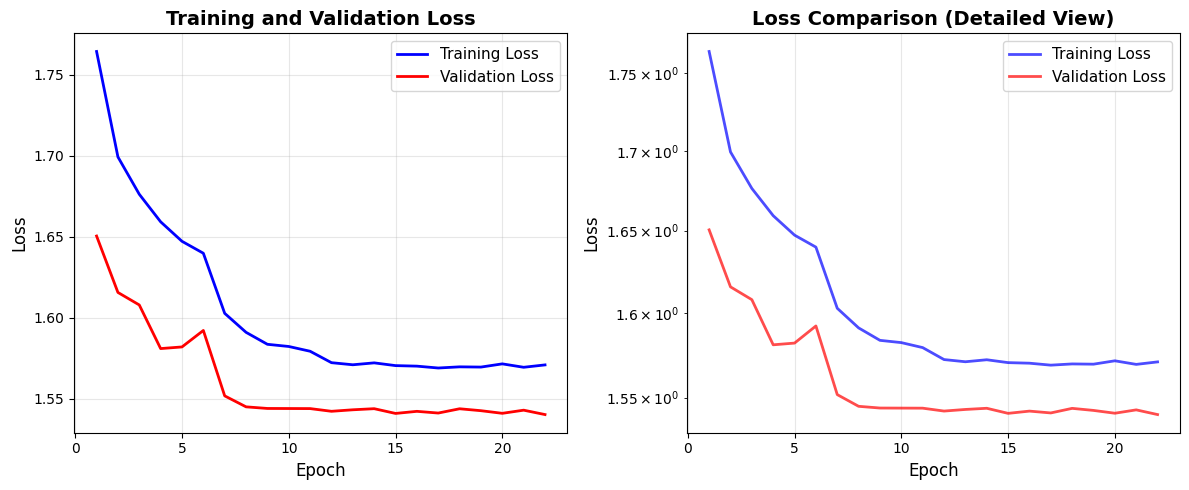


===== TRAINING SUMMARY =====
Final Training Loss: 1.5709
Final Validation Loss: 1.5402
Best Validation AUC: 0.8479
Total Epochs Trained: 22
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8030 | F1: 0.3868
[Test] Cardiomegaly AUC: 0.9249 | F1: 0.4803
[Test] Consolidation AUC: 0.7764 | F1: 0.2227
[Test] Edema AUC: 0.8957 | F1: 0.2734
[Test] Effusion AUC: 0.8990 | F1: 0.6060
[Test] Emphysema AUC: 0.9655 | F1: 0.5301
[Test] Fibrosis AUC: 0.8564 | F1: 0.1455
[Test] Hernia AUC: 0.9830 | F1: 0.6087
[Test] Infiltration AUC: 0.6983 | F1: 0.4155
[Test] Mass AUC: 0.9068 | F1: 0.4631
[Test] Nodule AUC: 0.7671 | F1: 0.3122
[Test] Pleural_Thickening AUC: 0.8015 | F1: 0.2400
[Test] Pneumonia AUC: 0.6817 | F1: 0.0385
[Test] Pneumothorax AUC: 0.8873 | F1: 0.3463
[Test] Avg AUC: 0.8462, Avg F1: 0.3621


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 1.6268
Avg AUROC : 0.8462
Avg F1    : 0.3621

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8030     0.3868     0.2088    
Cardiomegaly         0.9249     0.4803     0.2823    
Consolidation        0.7764     0.2227     0.1428    
Edema                0.8957     0.2734     0.2450    
Effusion             0.8990     0.6060     0.3433    
Emphysema            0.9655     0.5301     0.1033    
Fibrosis             0.8564     0.1455     0.1017    
Hernia               0.9830     0.6087     0.2337    
Infiltration         0.6983     0.4155     0.2878    
Mass                 0.9068     0.4631     0.4138    
Nodule               0.7671     0.3122     0.2540    
Pleural_Thickening   0.8015     0.2400     0.0897    
Pneumonia            0.6817     0.0385     0.1669    
Pneumothorax         0.8873     0.3463     0.2852    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

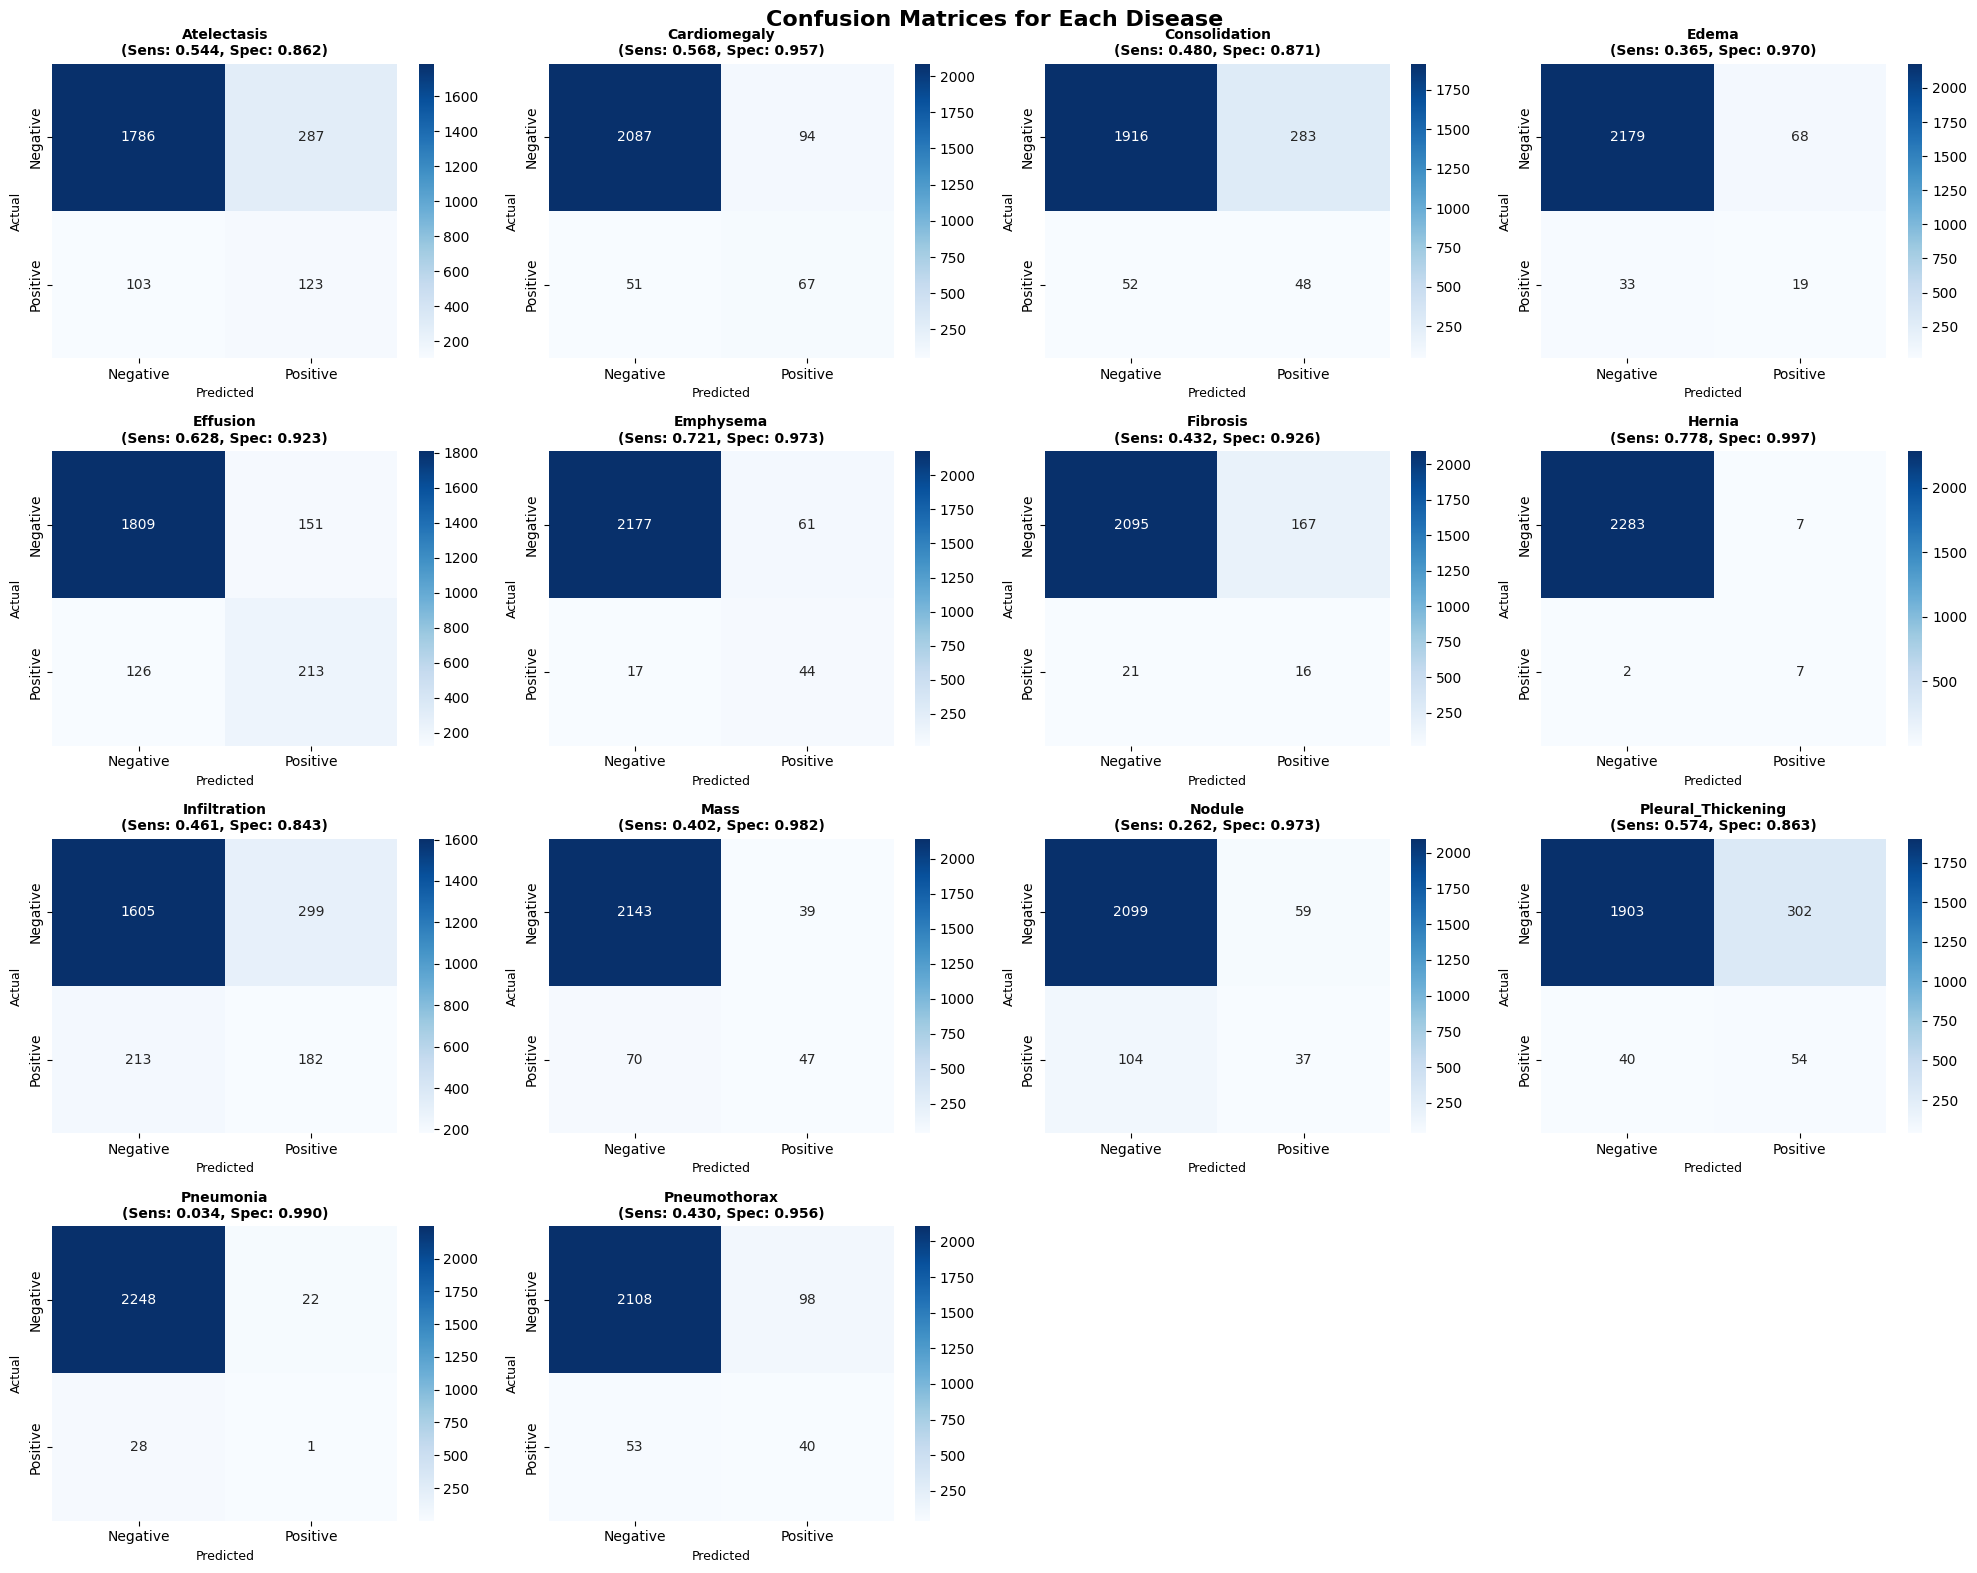

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          123    1786   287    103    0.544    0.862    0.300    0.945   
Cardiomegaly         67     2087   94     51     0.568    0.957    0.416    0.976   
Consolidation        48     1916   283    52     0.480    0.871    0.145    0.974   
Edema                19     2179   68     33     0.365    0.970    0.218    0.985   
Effusion             213    1809   151    126    0.628    0.923    0.585    0.935   
Emphysema            44     2177   61     17     0.721    0.973    0.419    0.992   
Fibrosis             16     2095   167    21     0.432    0.926    0.087    0.990   
Hernia               7      2283   7      2      0.778    0.997    0.500    0.999   
Infiltration         182    1605   299    213    0.461    0.843    0.378    0.883   
Ma